## Analyze A/B Test Results

<br>

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

df.rename(columns={'landing_page': 'page'}, inplace=True)
df.head()

,user_id,timestamp,group,page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
uq_user=df.user_id.nunique()
uq_user

290584

d. The proportion of users converted.

In [5]:
conv_uq_user=df.query('converted == 1').user_id.nunique()
conv_uq_user/uq_user

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df.query('(group == "treatment" & page != "new_page")')) + len(df.query('(group == "control" & page != "old_page")'))

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  int64 
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.drop(index=df.query('(group == "treatment" & page != "new_page")').index)
df2.drop(index=df.query('(group == "control" & page != "old_page")').index, inplace=True)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2.user_id.duplicated(keep=False).sum()

2

c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.query('(index == 1899 | index == 2893)')

,user_id,timestamp,group,page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
c_all=df2[df2['converted']==1].shape[0] / df2.shape[0]
c_all

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
c_old = df2.query('group == "control"')['converted'].mean()
c_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
c_new=df2.query('group == "treatment"')['converted'].mean()
c_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('group == "treatment"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [19]:
(c_new - c_old)*100

-0.15782389853555567

**Answer:** Based on descriptive statistics we see that the conversion rate for the new treatment page is with 11.88% 0.16 pp lower than for the control group (12.04%). Therefore we **cannot** assume yet that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0} = p_{new} - p_{old} \leq 0 $

$H_{1} = p_{new} - p_{old} > 0 $

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
#considering p(new) being equal to conversion rate regardless of page:
c_all

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
#considering p(old) being equal to conversion rate regardless of page:
c_all

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2[df2['group'] == "treatment"].shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2[df2['group'] == "control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-c_all, c_all])
new_page_converted.mean()

0.11853967380083959

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-c_all, c_all])
old_page_converted.mean()

0.1190577804700084

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
obs_diff=new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.000518106669168808

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs=[]

for x in range(10000):
    npc = np.random.choice([0, 1], size=n_new, p=[1-c_all, c_all]).mean()
    opc = np.random.choice([0, 1], size=n_old, p=[1-c_all, c_all]).mean()
    p_diffs.append(npc-opc)

In [28]:
p_diffs=np.array(p_diffs)
p_diffs.mean()

7.4224686842960795e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

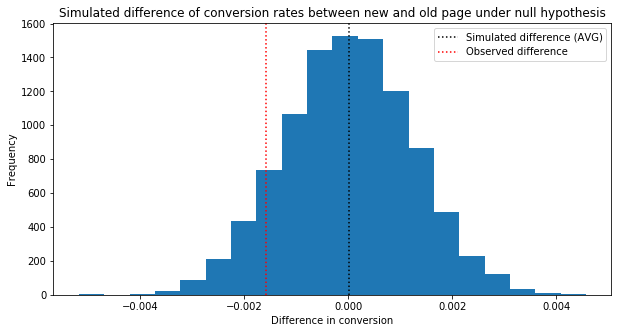

In [29]:
plt.figure(figsize=(10,5))
plt.title('Simulated difference of conversion rates between new and old page under null hypothesis')
plt.xlabel('Difference in conversion')
plt.ylabel('Frequency')
plt.hist(p_diffs, bins=20)
plt.axvline(p_diffs.mean(), c='k', label='Simulated difference (AVG)', linestyle=':')
plt.axvline((c_new - c_old), c='r', label='Observed difference', linestyle=':')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > (c_new - c_old)).mean()

0.8988

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** We computed in part **j** a p-value of 90.93%, meaning there is a chance of c.90.93% to observe our statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. 

This means, we do not have statistical evidence to reject $H_{0}$ considering an $\alpha$ of 5%.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
df2.head(1)

,user_id,timestamp,group,page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [32]:
import statsmodels.api as sm

convert_old = df2.query('page == "old_page"')['converted'].sum()
convert_new = df2.query('page == "new_page"')['converted'].sum()
n_old = df2.query('page == "old_page"').shape[0]
n_new = df2.query('page == "new_page"').shape[0]

In [33]:
print('Hits on old page: '+str(n_old)+', thereof converted: '+str(convert_old))
print('Hits on new page: '+str(n_new)+', thereof converted: '+str(convert_new))

Hits on old page: 145274, thereof converted: 17489
Hits on new page: 145310, thereof converted: 17264


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [35]:
pold=convert_old/n_old
varold=np.sqrt( pold*(1-pold)/n_old )
varold

pold+z_score*varold

0.11926707753309725

In [36]:
pnew=convert_new/n_new
varnew=np.sqrt( pnew*(1-pnew)/n_new )

pold+z_score*varnew

0.11927357898240067

In [37]:
convert_new/n_new

0.11880806551510564

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** 
- The z-score indicates, that the new conversion rate is $1.31 \times \sigma$ below the old conversion rate
- The p-value shows, that that the probability of observing the new conversion rate (or one that is more extreme in favor of the alternative hypothesis) is 90.5%; considering $\alpha$ of 5%, we cannot reject $H_{0}$

The findings are in line with the results of questions j & k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2['ab_page']=pd.get_dummies(df.group)['treatment']
df2['intercept']=1
df2.head()

,user_id,timestamp,group,page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
lm=sm.Logit(df2.converted, df2[['ab_page', 'intercept']])
res=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:59:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

In [41]:
#exponentiate coefficients, calculate the inverse as values are negative:
for a, x in enumerate(res.params):
    print(res.params.index[a]+": "+str(1/np.exp(res.params[a])))

ab_page: 1.015102013696476
intercept: 7.306592715421111


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:** The p-value of *ab_page* of 0.19 indicates that we fail to reject $H_{0}$. 

In Part II, our $H_{0}$ states that the new page results in **as many or less** conversions than the old page.

In Part III, we use a logistic regression to determine the p-value. Our $H_{0}$ states that the new page creates **as many** conversions as the old page, while $H_{1}$ states that the conversion rate of the new page is **higher or lower**. That means we are using a two-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** When performing a regression it is important to choose variables that have an impact on the results. Results can depend on multiple factors, meaning that increasing the number of variables can increase the explanation level of our model. On the other hand, by adding factors we also increase the complexity of our model. Therefore it is important to balance between complexity and level of explanation of our model.
 
Based on the logistic regression discussed above we can see that the old resp. new page is not statistically significant in assessing the conversion rate. Therefore it makes sense to include additional variables to our model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
### Create the necessary dummy variables
df_new=df_new.join(pd.get_dummies(df_new.country))
df_new.head()

,country,timestamp,group,page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
lm_new=sm.Logit(df_new.converted, df_new[['CA', 'UK', 'intercept']])
res_new=lm_new.fit()
res_new.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:59:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

**Answer:** With p-values of 0.13 and 0.46 for for CA resp. UK we can assume that the country is not statistically relevant in determining the conversion. Meaning we fail to reject $H_{0}$ which concludes that the country is not statistically significant in determining the conversion. 

In [45]:
lm_new=sm.Logit(df_new.converted, df_new[['ab_page', 'CA', 'UK', 'intercept']])
res_new=lm_new.fit()
res_new.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        16:59:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
==============================================================================
"""

**Conclusion:** By creating another regression model containing the country and page variables we can see that for all 3 variables the p-values are above 5%. Therefore we can conclude that neither the country nor the new page have a statistically significant effect on the conversion rate.

Going back to our hypothesis:

$H_{0} = p_{new} - p_{old} \leq 0 $

$H_{1} = p_{new} - p_{old} > 0 $

We can conclude that we do not have statistical evidence to reject $H_{0}$, meaning we can advice the company to keep the current page.

*** 
**Bonus**
***

`2.` Adding datetime variables to logistic regression based on weekdays and time of the day:
- see if weekdays/weekends have an impact on conversion rate
- see if time of the day (morning, afternoon, evening) have an impact on conversion rate

In [46]:
#create new DF, convert timestamp to datetime, set timestamp to index
df_time=df2
df_time['timestamp']=pd.to_datetime(df_time.timestamp)
df_time.set_index('timestamp', inplace=True)
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 290584 entries, 2017-01-21 22:11:48.556739 to 2017-01-16 12:40:24.467417
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290584 non-null  int64 
 1   group      290584 non-null  object
 2   page       290584 non-null  object
 3   converted  290584 non-null  int64 
 4   ab_page    290584 non-null  uint8 
 5   intercept  290584 non-null  int64 
dtypes: int64(3), object(2), uint8(1)
memory usage: 13.6+ MB


In [47]:
# add column to specify for weekday (Mon-Fri: 1, Sat+Sun: 0)
df_time['weekday']=np.where(((df_time.index.weekday == 5) | (df_time.index.weekday == 6)), 0, 1)

In [48]:
# add column to filter for time ranges:
# 6 am - 2 pm: morning
# 2 pm - 8 pm: afternoon
# 8 pm - 6 am: night

conditions=[
            (df_time.index.isin(df_time.between_time('6:00', '14:00').index)),
            (df_time.index.isin(df_time.between_time('14:00', '20:00').index)),
            (df_time.index.isin(df_time.between_time('20:00', '06:00').index))
            ]

choices=['morning', 'afternoon', 'night']
df_time['time']=np.select(conditions, choices)

In [49]:
# dummy variables for time ranges:
df_time=df_time.join(pd.get_dummies(df_time.time))
df_time.head()

,user_id,group,page,converted,ab_page,intercept,weekday,time,afternoon,morning,night
timestamp,,,,,,,,,,,
2017-01-21 22:11:48.556739,851104,control,old_page,0,0,1,0,night,0,0,1
2017-01-12 08:01:45.159739,804228,control,old_page,0,0,1,1,morning,0,1,0
2017-01-11 16:55:06.154213,661590,treatment,new_page,0,1,1,1,afternoon,1,0,0
2017-01-08 18:28:03.143765,853541,treatment,new_page,0,1,1,0,afternoon,1,0,0
2017-01-21 01:52:26.210827,864975,control,old_page,1,0,1,0,night,0,0,1


In [50]:
#Set up model:
res_time = sm.Logit(df_time.converted, df_time[['weekday', 'afternoon', 'morning', 'intercept']]).fit()
res_time.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               2.283e-05
Time:                        16:59:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1825
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       -0.0006      0.013     -0.047      0.962      -0.026       0.025
afternoon      0.0225      0.014      1.558      0.119      -0.006       0.051
morning        0.0274      0.013      2.061      0.039       0.001       0.053
intercept     -2.0106      0.013   -155.927      0.000      -2.036      -1.985
==============================================================================
"""

In [51]:
for a, x in enumerate(res_time.params):
        print(res_time.params.index[a]+": "+str(np.exp(res_time.params[a])))

weekday: 0.9993965791775653
afternoon: 1.022782370835269
morning: 1.0277764755203826
intercept: 0.13390256510659537


**Conclusion:** While the weekday does not have a significant impact on conversion rate (p-value > 0.05), we can see that the `morning` variable has a p-value of 0.039 and therefore has statistical significance:<br><br>


Using the timerange from 8 pm to 6 am (`night`) as the baseline, we can say that a conversion in the morning is 1.027x more likely, holding all else constant. 